In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy

from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import make_lupton_rgb

import lenstronomy.Util.util as util
from lenstronomy.SimulationAPI.sim_api import SimAPI

In [2]:
# Properties of the DES camera & bands
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 4.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 36.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 7,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

DES_r_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 36.7,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

DES_i_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 36.1,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

# numpix = size in arcseconds/ pixel scale (0.2637)
numpix = 65
kwargs_numerics = {'point_source_supersampling_factor': 1}
# Cosmology parameters
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

In [3]:
# Color distribution selected from a random distribution of galaxies
colors = pd.read_csv('color_distribution/source_colors.csv')
colors = colors[colors['DNF_ZMEAN_MOF'] > 0.01] #When there is no data z<0
colors = colors[colors['MAG_PSF_G'] < 30.] [colors['MAG_PSF_R'] < 30.] [colors['MAG_PSF_I'] < 30.] #decent magnitude
colors['g_r'] = colors['MAG_PSF_G'] - colors['MAG_PSF_R'] # g-r color
colors['r_i'] = colors['MAG_PSF_R'] - colors['MAG_PSF_I'] # r-i color

dz = 0.1 # Range of redshift for filtering
dm = 0.2 # Range of magnitude for filtering

def color_distribution(z, m):
    #objects with a redshift between z - dz and z + dz, same idea for apparent magnitude
    fcolors = colors[(colors['DNF_ZMEAN_MOF'] > z - dz)] [(colors['DNF_ZMEAN_MOF'] < z + dz)] 
    fcolors = fcolors[(colors['MAG_PSF_G'] > m - dm)] [(colors['MAG_PSF_G'] < m + dm)]
    random_object = fcolors.sample()
    g_r = random_object['g_r'].values[0]
    r_i = random_object['r_i'].values[0]
    return(g_r, r_i)

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [4]:
def simulation(redshifts, sigma ,centers, lens_ellip, i):
    
    kwargs_model_physical = {'lens_model_list': ['SIE'],  # list of lens models to be used
                          'lens_redshift_list': [redshifts['lens']],  # list of redshift of the deflections
                          #'lens_light_model_list': ['SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                          'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC'],  # list of extended source models to be used
                          # list of redshfits of the sources in same order as source_light_model_list
                          'source_redshift_list': [redshifts['source1'], redshifts['source2']],
                          'cosmo': cosmo,  # astropy.cosmology instance
                          'z_source': z_source2} # redshift of the default source (if not further specified by 'source_redshift_list') 
                           #and also serves as the redshift of lensed point sources}

    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_physical)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_physical)
    
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    kwargs_mass = [{'sigma_v': sigma, 'center_x': centers['lens'][0], 'center_y': centers['lens'][1], 'e1': lens_ellip[0], 'e2': lens_ellip[1]}]
    kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)

    #colors of the other bands for each source
    g_r_source_1, r_i_source_1 = color_distribution(redshifts['source1'], 22)
    g_r_source_2, r_i_source_2 = color_distribution(redshifts['source2'], 23)
    
    #sources light:
    kwargs_source_mag_g_1 = [{'magnitude': 22, 'R_sersic': 0.3, 'n_sersic': 1.5, 'e1': 0., 'e2': 0., 
                              'center_x': centers['source1'][0], 'center_y': centers['source1'][1]}]
    kwargs_source_mag_g_2 = [{'magnitude': 23, 'R_sersic': 0.3, 'n_sersic': 1.5, 
                              'center_x': centers['source2'][0], 'center_y': centers['source2'][0]}]
    
    kwargs_source_mag_r_1 = copy.deepcopy(kwargs_source_mag_g_1)
    kwargs_source_mag_r_2 = copy.deepcopy(kwargs_source_mag_g_2)
    kwargs_source_mag_i_1 = copy.deepcopy(kwargs_source_mag_r_1)
    kwargs_source_mag_i_2 = copy.deepcopy(kwargs_source_mag_r_2)
    
    kwargs_source_mag_r_1[0]['magnitude'] -= g_r_source_1
    kwargs_source_mag_r_2[0]['magnitude'] -= g_r_source_2
    kwargs_source_mag_i_1[0]['magnitude'] -= r_i_source_1
    kwargs_source_mag_i_2[0]['magnitude'] -= r_i_source_2
    
    kwargs_source_mag_g = kwargs_source_mag_g_1 + kwargs_source_mag_g_2
    kwargs_source_mag_r = kwargs_source_mag_r_1 + kwargs_source_mag_r_2
    kwargs_source_mag_i = kwargs_source_mag_i_1 + kwargs_source_mag_i_2
    
    kwargs_lens_light_g, kwargs_source_g , point = sim_g.magnitude2amplitude(kwargs_lens_light_mag=None, kwargs_source_mag=kwargs_source_mag_g, kwargs_ps_mag=None)
    kwargs_lens_light_r, kwargs_source_r , point = sim_r.magnitude2amplitude(kwargs_lens_light_mag=None, kwargs_source_mag=kwargs_source_mag_r, kwargs_ps_mag=None)
    kwargs_lens_light_i, kwargs_source_i , point = sim_i.magnitude2amplitude(kwargs_lens_light_mag=None, kwargs_source_mag=kwargs_source_mag_i, kwargs_ps_mag=None)
    
    image_g = imSim_g.image(kwargs_lens, kwargs_source_g)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_r)
    image_i = imSim_i.image(kwargs_lens, kwargs_source_i)
    
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)
    image_i += sim_i.noise_for_model(model=image_i)
    
    rgb = make_lupton_rgb(image_i, image_r, image_g, Q=15., stretch=80.)
    
    plt.figure()
    plt.imshow(rgb)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.savefig('Image' + str(i) + '.png')
    plt.show(block=True)

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


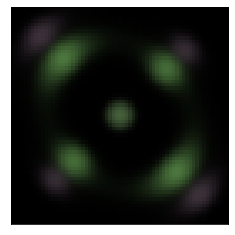

In [5]:
#The seeing of the simulations should correspond to the seeing of the real images, here random
DES_g_band_obs['seeing'] = 1.2
DES_r_band_obs['seeing'] = 1.2
DES_i_band_obs['seeing'] = 1.2
kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

z_lens, z_source1, z_source2 = .2, .5, 1.3
redshifts = {'lens': z_lens, 'source1': z_source1, 'source2': z_source2}
dispersion = 600
lens_ellip = [0,-0.3]
center_lens, center_source1, center_source2 = [0,0], [0,0], [0,0]
centers = {'lens': center_lens, 'source1': center_source1, 'source2': center_source2}

simulation(redshifts, dispersion, centers, lens_ellip, 1)

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


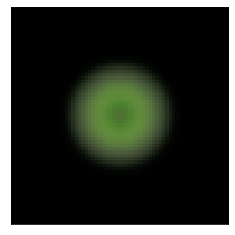

In [6]:
DES_g_band_obs['seeing'] = 1.3
DES_r_band_obs['seeing'] = 1.4
DES_i_band_obs['seeing'] = 1.3
kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

z_lens, z_source1, z_source2 = .4, .7, 1.2
redshifts = {'lens': z_lens, 'source1': z_source1, 'source2': z_source2}
dispersion = 400
center_lens, center_source1, center_source2 = [0,0], [0,0], [0,0]
centers = {'lens': center_lens, 'source1': center_source1, 'source2': center_source2}
lens_ellip = [0,0]
simulation(redshifts, dispersion, centers, lens_ellip, 2)

In [7]:
#Ploting a real image
#from IPython.display import Image
#Image(filename='Data/a_real_image.png')
#Image(filename='Image1.png')

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


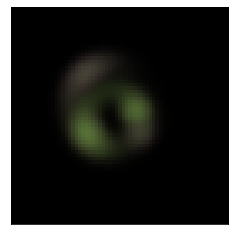

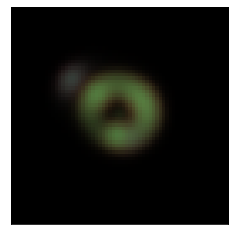

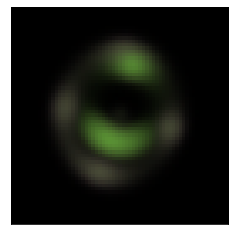

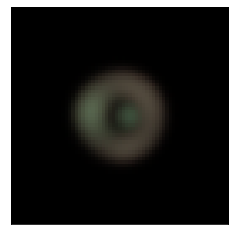

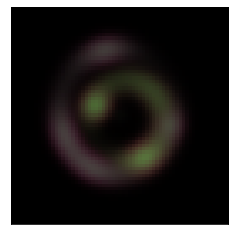

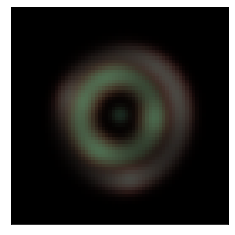

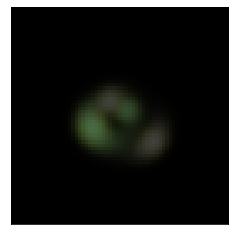

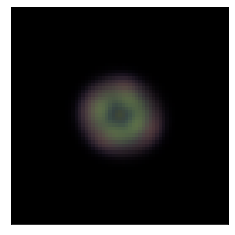

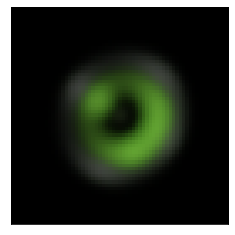

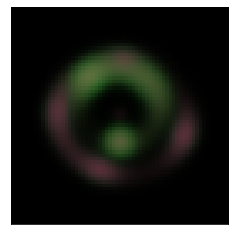

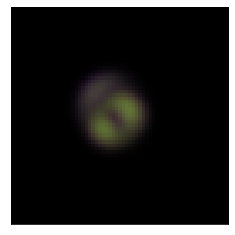

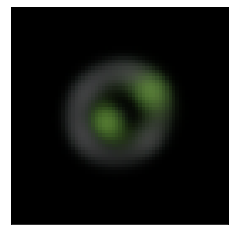

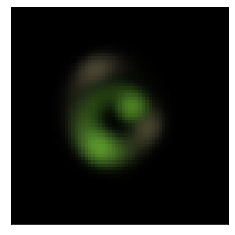

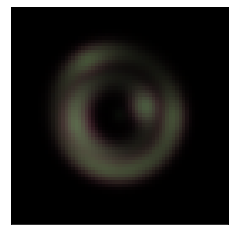

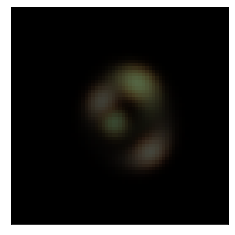

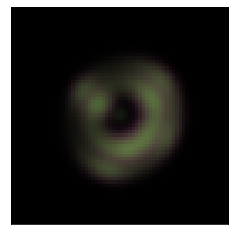

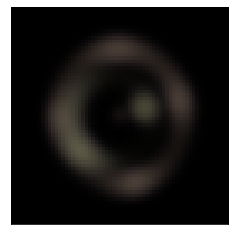

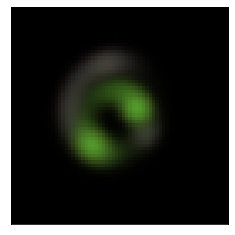

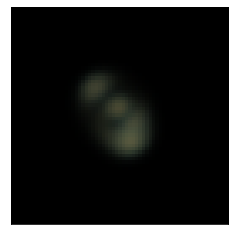

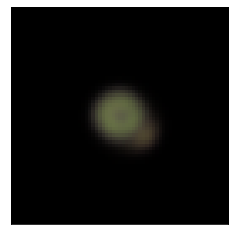

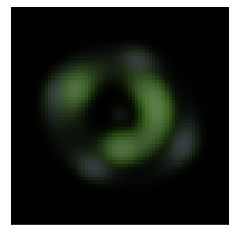

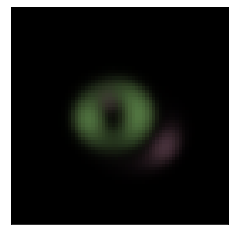

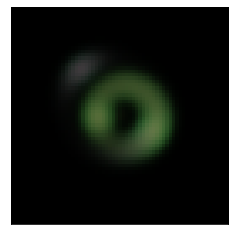

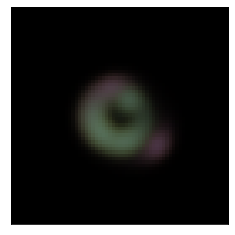

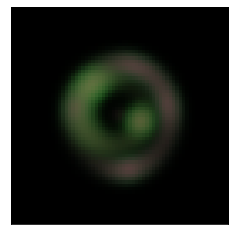

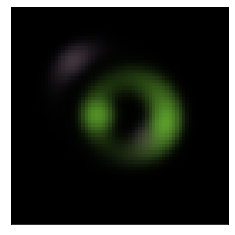

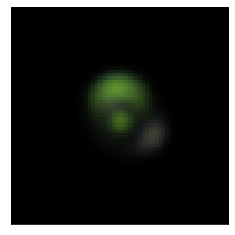

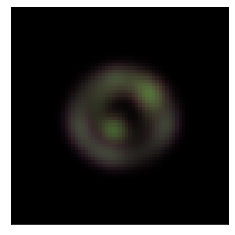

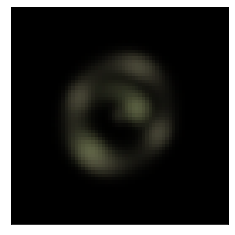

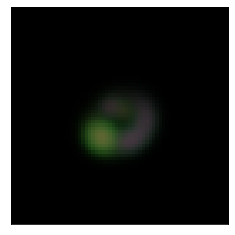

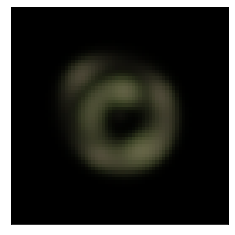

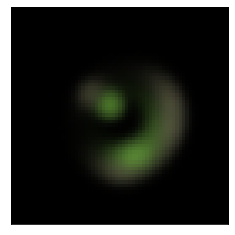

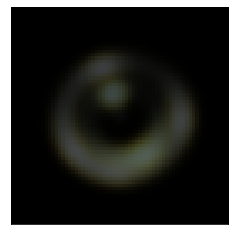

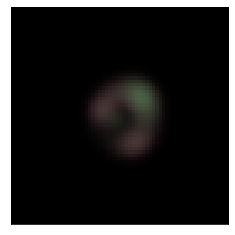

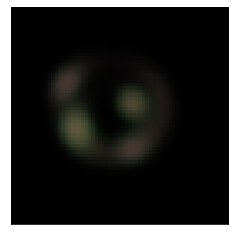

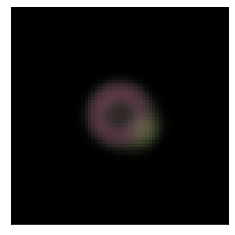

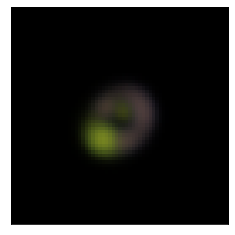

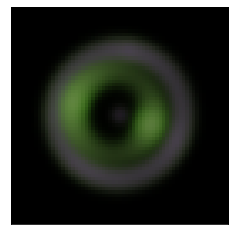

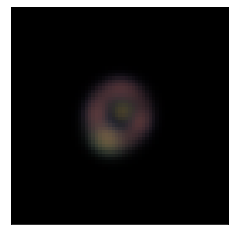

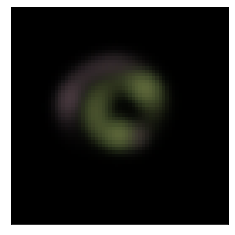

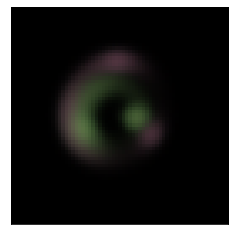

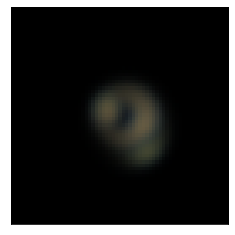

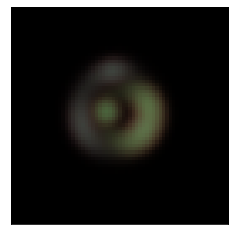

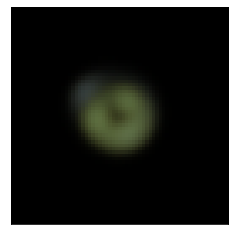

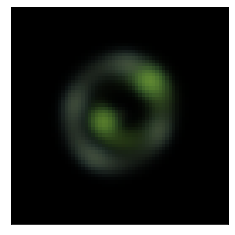

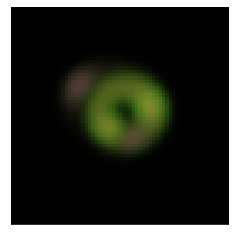

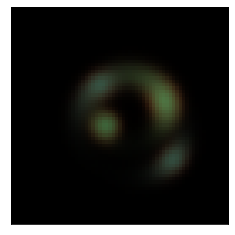

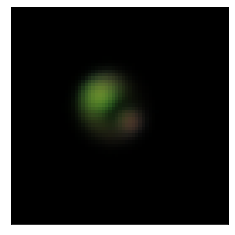

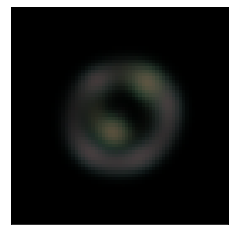

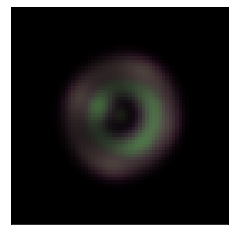

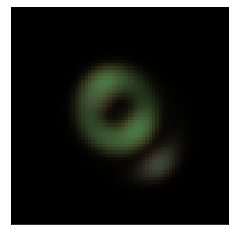

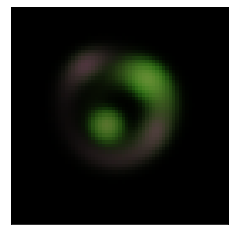

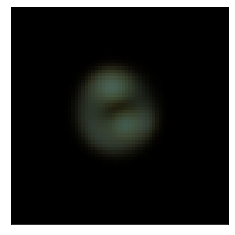

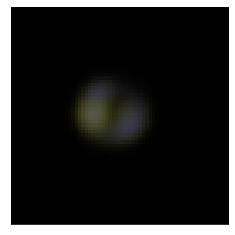

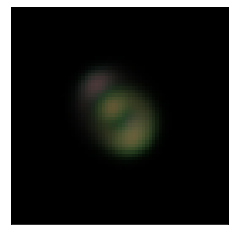

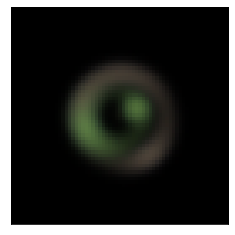

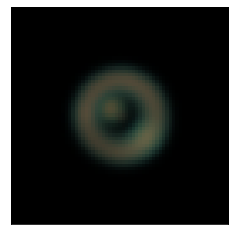

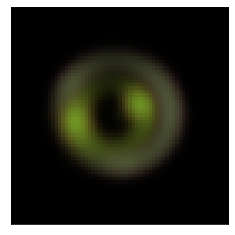

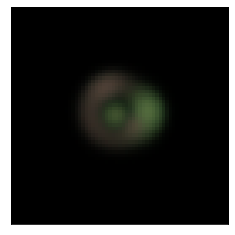

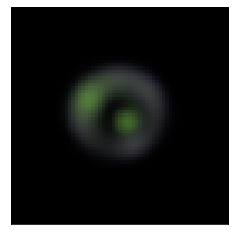

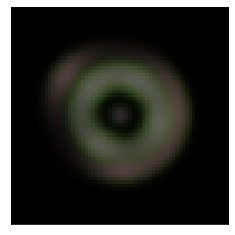

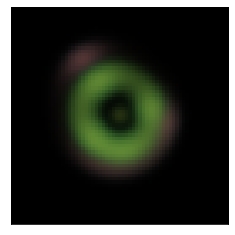

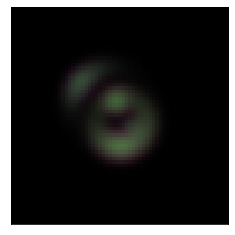

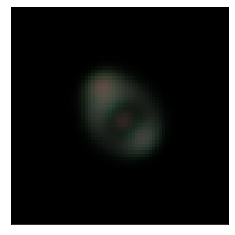

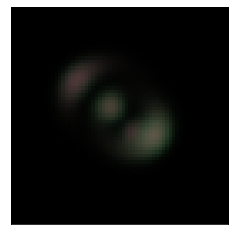

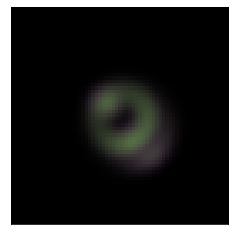

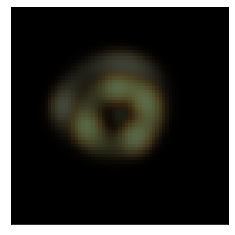

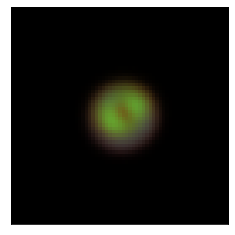

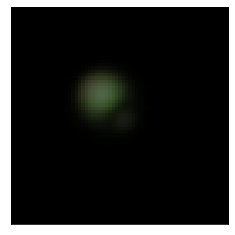

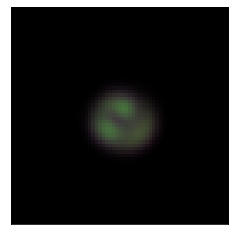

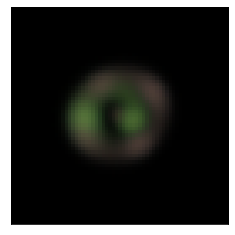

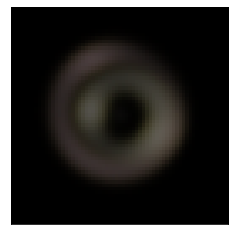

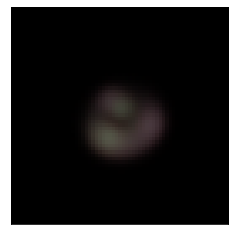

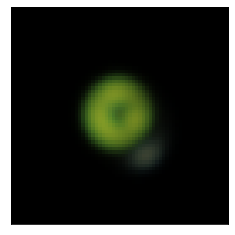

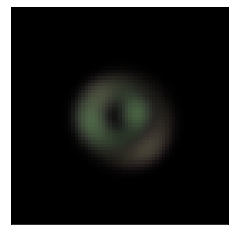

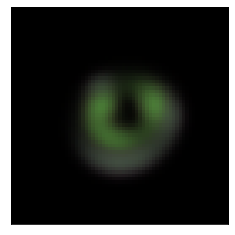

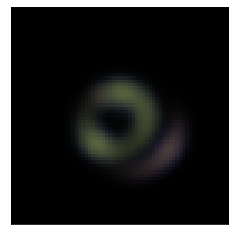

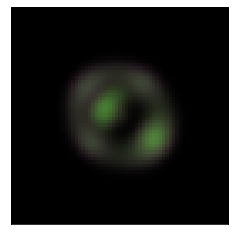

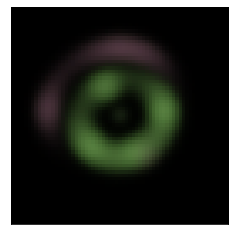

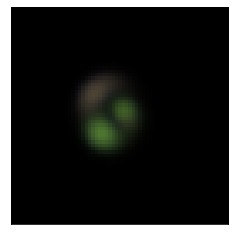

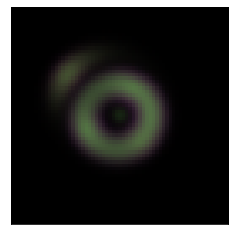

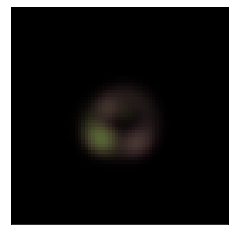

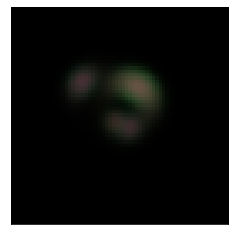

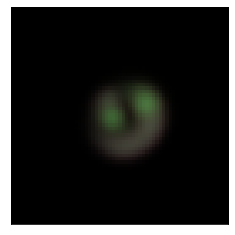

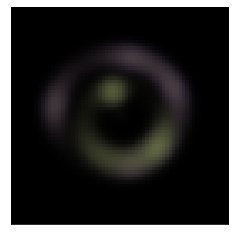

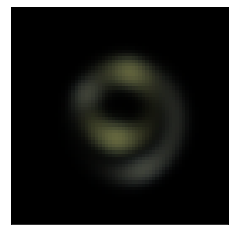

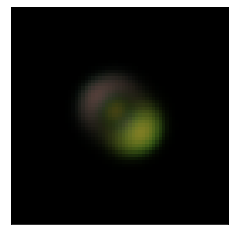

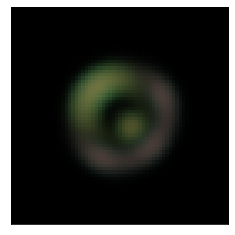

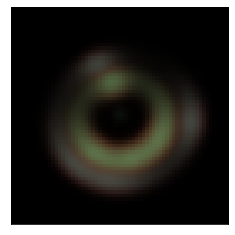

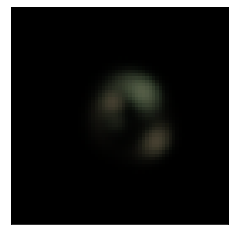

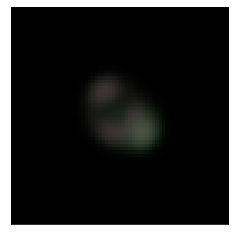

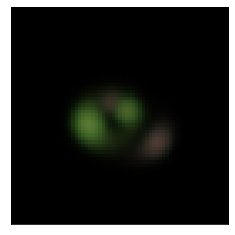

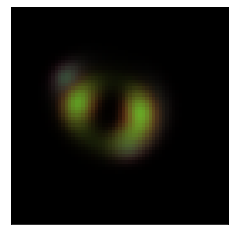

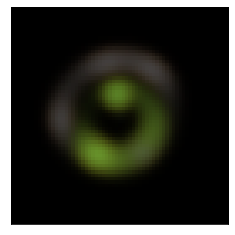

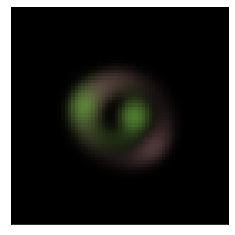

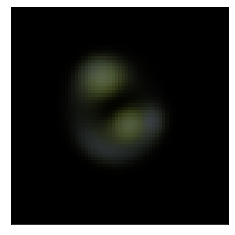

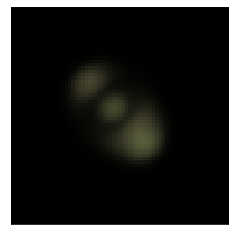

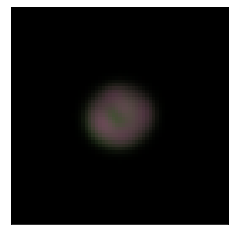

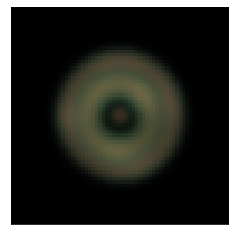

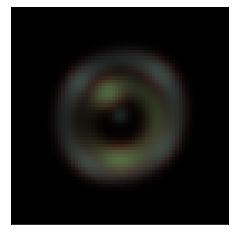

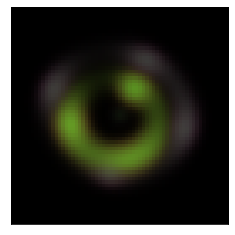

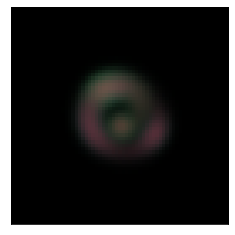

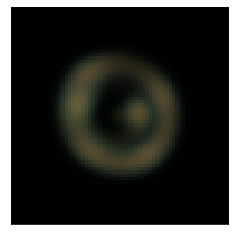

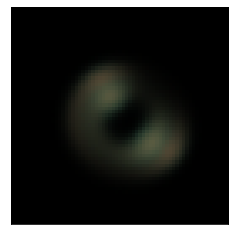

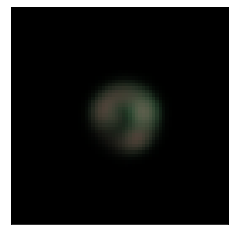

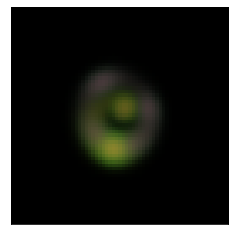

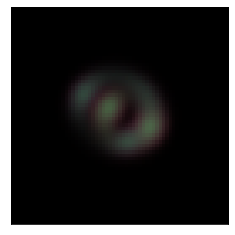

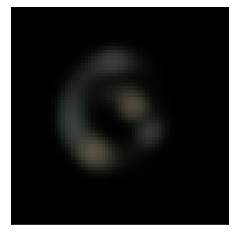

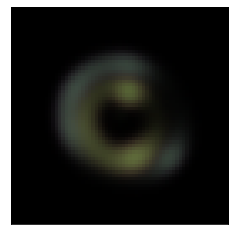

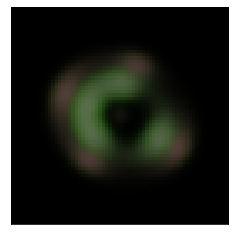

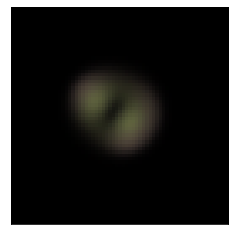

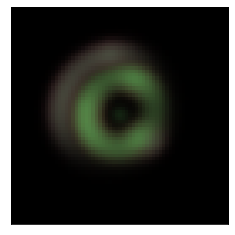

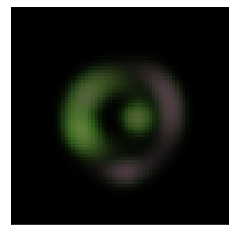

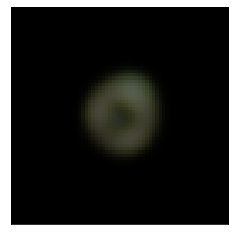

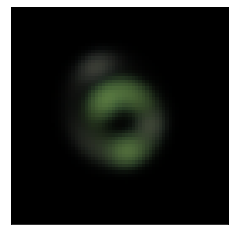

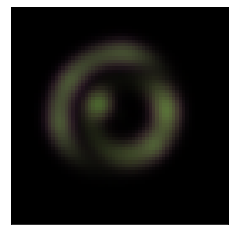

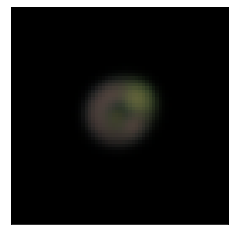

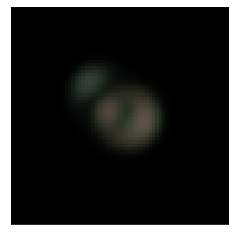

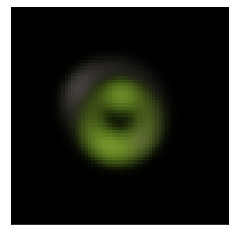

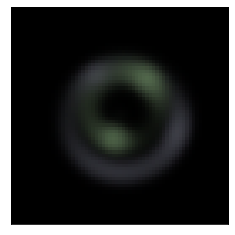

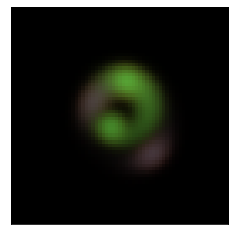

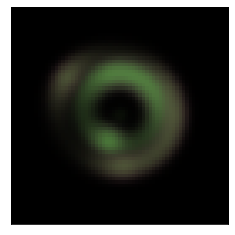

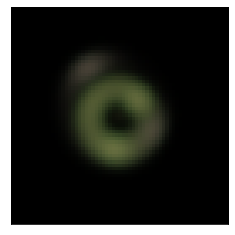

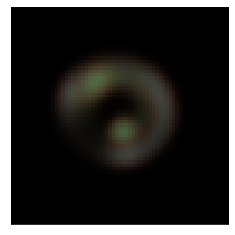

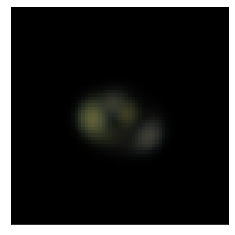

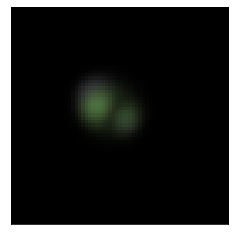

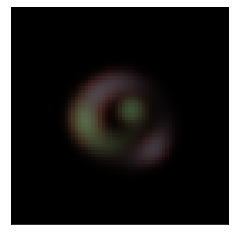

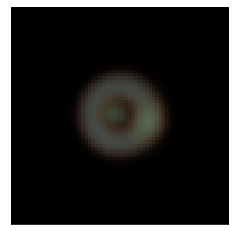

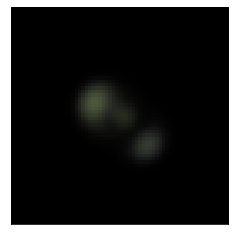

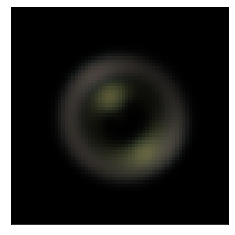

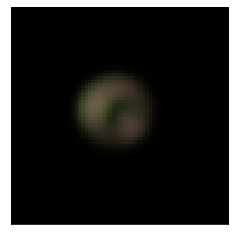

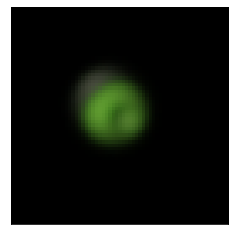

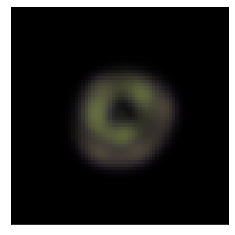

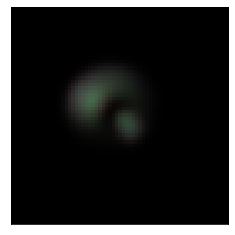

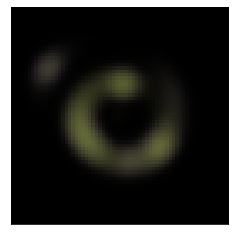

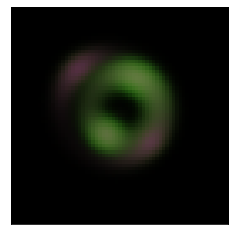

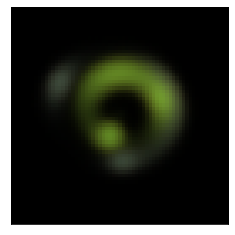

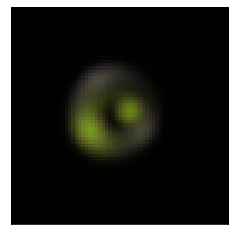

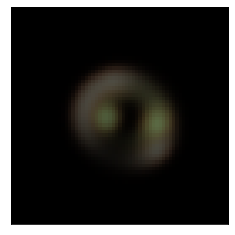

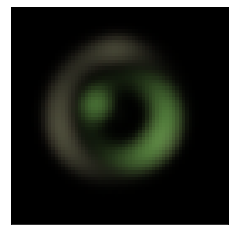

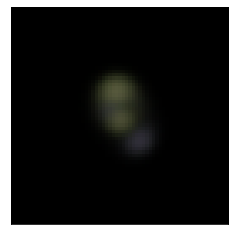

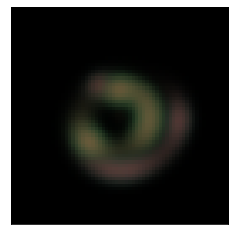

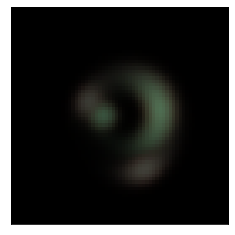

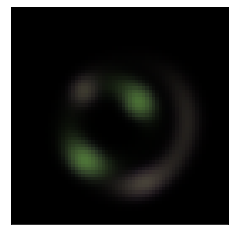

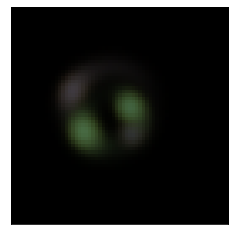

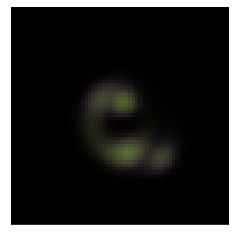

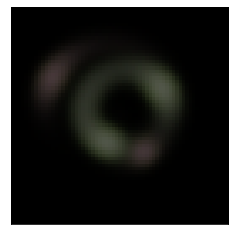

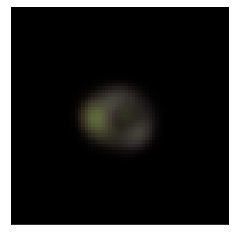

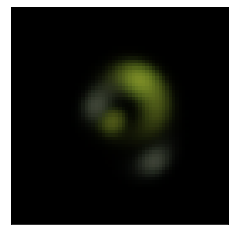

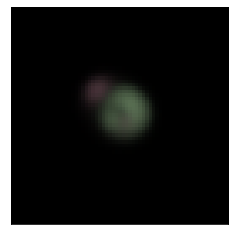

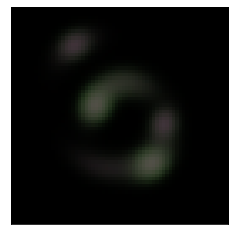

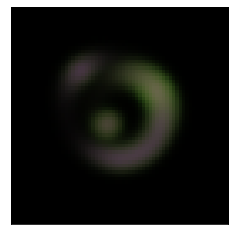

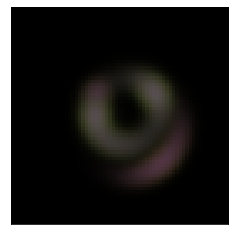

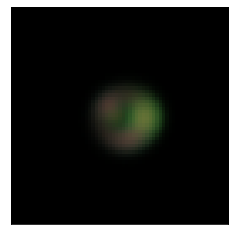

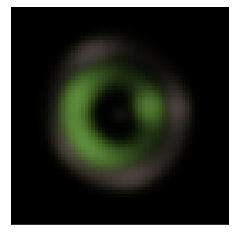

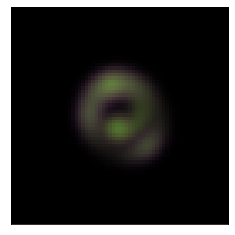

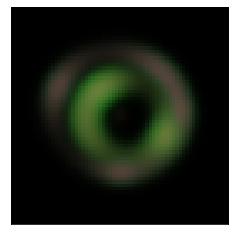

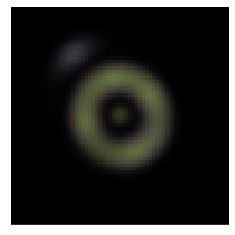

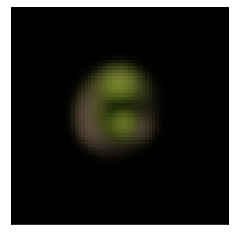

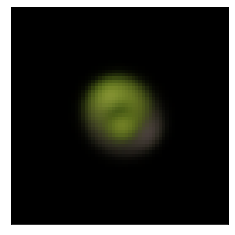

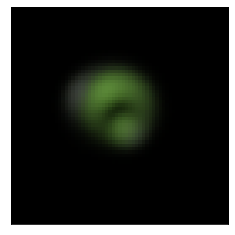

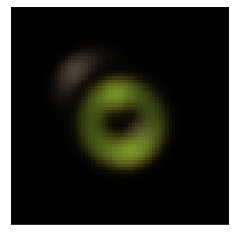

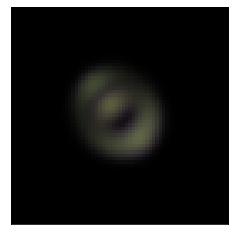

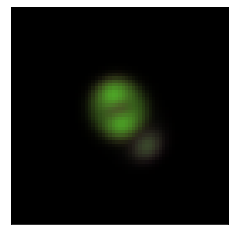

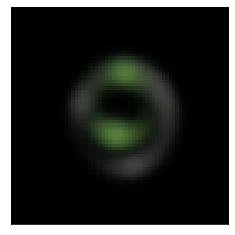

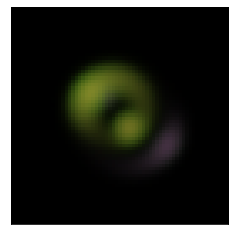

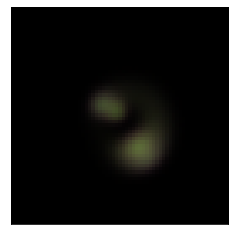

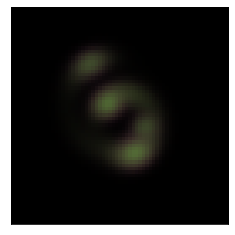

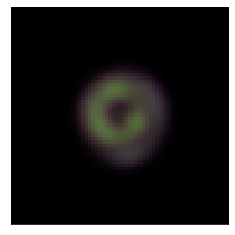

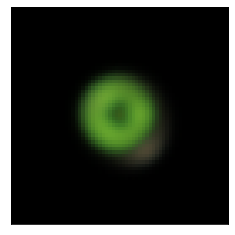

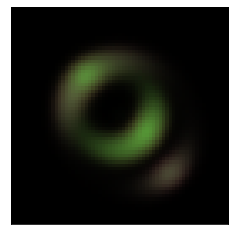

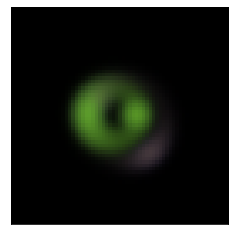

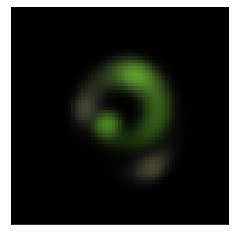

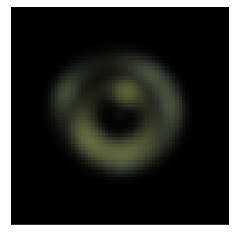

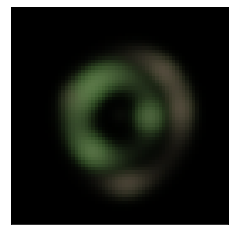

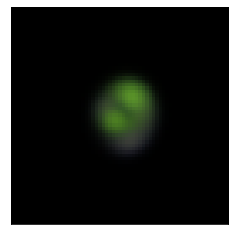

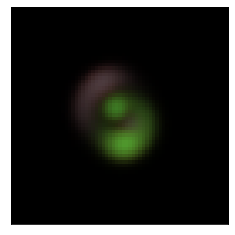

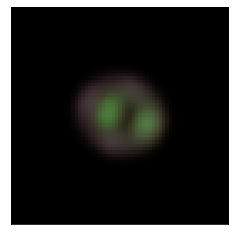

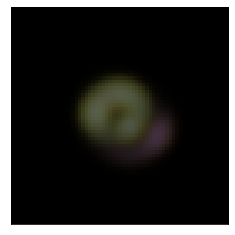

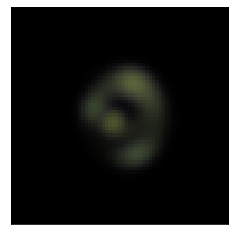

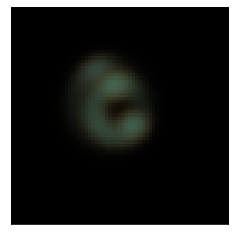

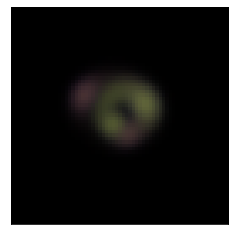

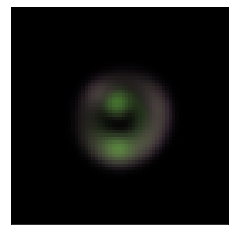

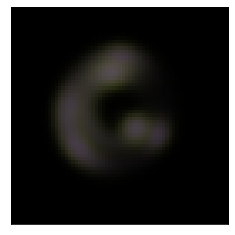

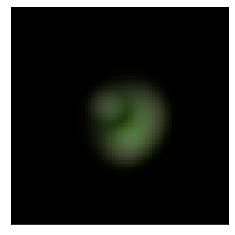

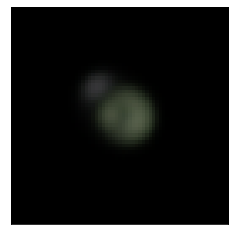

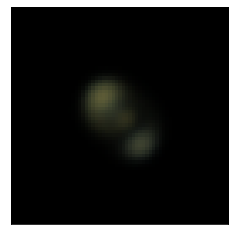

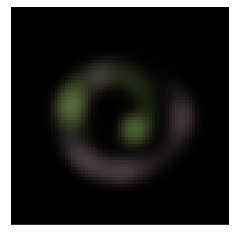

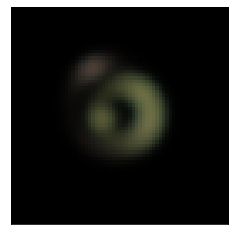

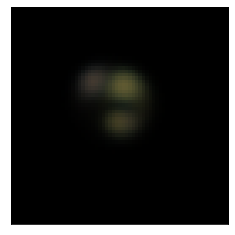

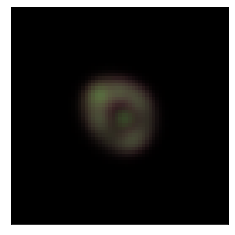

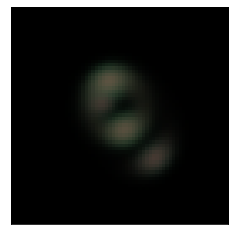

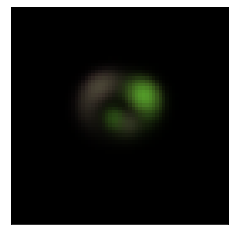

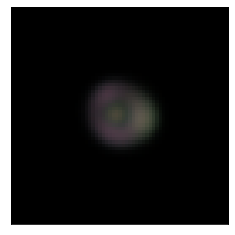

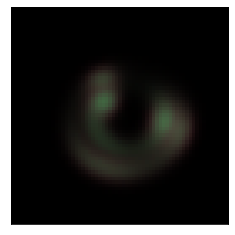

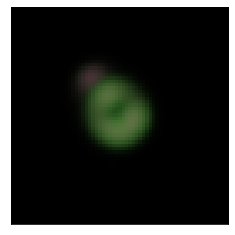

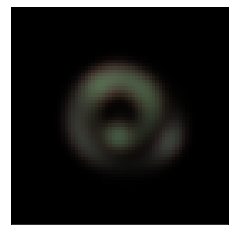

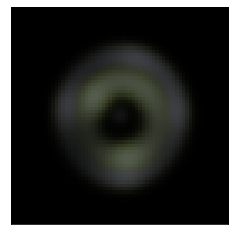

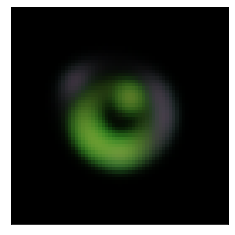

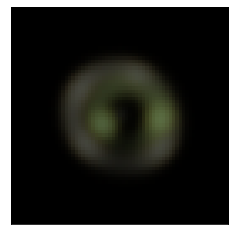

In [8]:
for i in range(0,200):
    DES_g_band_obs['seeing'] = random.uniform(1.0,1.3)
    DES_r_band_obs['seeing'] = random.uniform(1.0,1.3)
    DES_i_band_obs['seeing'] = random.uniform(1.0,1.3)
    kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
    kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
    kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

    zlens = random.uniform(0.01,0.6)
    zsource1 = random.uniform(zlens, 1.2)
    zsource2 = random.uniform(zsource1, 1.3)
    redshifts = {'lens': z_lens, 'source1': z_source1, 'source2': z_source2}
    dispersion = random.uniform(300, 550)
    center_source1 = [random.uniform(-1, 1), random.uniform(-1, 1)]
    center_source2 = [random.uniform(-1, 1), random.uniform(-1, 1)]
    lens_ellip = [random.uniform(-0.2, 0.2), random.uniform(-0.2, 0.2)]
    centers = {'lens': center_lens, 'source1': center_source1, 'source2': center_source2}
    simulation(redshifts, dispersion, centers, lens_ellip, i)

In [9]:
! convert -delay 50 -loop 0 *.png Only_sources.gif
! rm *.png